For each practical exercise (TP), please work in groups of two or three. Then, create a **private GitHub repository** and add me (my GitHub is **arthur-75**) to your project. Finally, share the link to your project (or TP) under  [Practical Exercises](https://docs.google.com/spreadsheets/d/1V-YKgHn71FnwjoFltDhWsPJS7uIuAh9lj6SP2DSCvlY/edit?usp=sharing) and make sure to choose your **team name** :-)

# **Joint Energy-Based Models (JEM)**

## **1\. Understanding Energy-Based Models (EBMs)**

### **1.1 What is an Energy-Based Model (EBM)?**

An Energy-Based Model (EBM) defines a probability distribution through an energy function Eθ(x). The lower the energy, the more probable the input. the probability distribution is defined as:  
        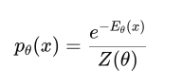

where:

* Eθ​(x) is the energy function.  
*  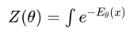 is the partition function (normalization constant).

### **1.2 Joint Energy-Based Model (JEM)**

JEM extends EBMs to also work as a classifier. Instead of defining only pθ​(x), it also models pθ​(y∣x), meaning:  
        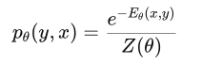

which enables both classification and generative modeling.

We decompose the energy into two parts:

1. **Classification logits**: fθ(x) (Neural Network output).  
2. **Energy Function**: Extracted from feature representations.

The probability of a class label is then:  
            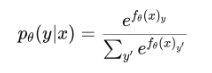

which is just a standard softmax classification.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import random as random
import torchvision
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_shape = (1, 28, 28)
batch_size = 64
num_classes = 10
lr = 1e-4
beta1 = 0.0
alpha = 0.1 
epochs = 10



## **2\. Designing the JEM Model**

### **2.1 Neural Network Structure**

The model consists of:

1. **CNN-based feature extractor** (convolutional layers for learning representations).  
2. **Two outputs**:  
   * **Energy output**: Eθ​(x), which determines sample likelihood.  
   * **Classification logits**: fθ(x), which classifies the sample.

The training objective involves:

* Standard **cross-entropy loss** for classification.  
* **Contrastive divergence** to train the energy model.

In [3]:

class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)
        
class JEMClassifier(nn.Module):
    def __init__(self, hidden_features=32):
        super().__init__()
        c_hid1 = hidden_features // 2
        c_hid2 = hidden_features
        c_hid3 = hidden_features * 2

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4),  # [16x16]
            Swish(),
            nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1),  # [8x8]
            Swish(),
            nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1),  # [4x4]
            Swish(),
            nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1),  # [2x2]
            Swish(),
            nn.Flatten()
        )
        self.fc_energy = nn.Linear(c_hid3 * 4, 1) 
        self.fc_class = nn.Linear(c_hid3 * 4, num_classes)

    def forward(self, x):
        features = self.cnn_layers(x)
        energy = self.fc_energy(features).squeeze(-1)
        logits = self.fc_class(features)
        return energy, logits
    


### **2.2 Computing Energy**

* In a CNN, the **feature representation** of an input x is used to compute energy:  
  Eθ​(x)=Linear(features)

where the features are extracted from the convolutional layers.



##  **3\. Sampling from the Model**

### **3.1 Markov Chain Monte Carlo (MCMC) Sampling**

Since the energy model defines an implicit probability distribution, we **cannot directly sample from it**. Instead, we use **Langevin Dynamics**, a gradient-based MCMC method.

The **Langevin update step** is:  
            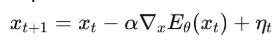
            
where:

* α is the step size.  
* ∇xEθ(xt) is the gradient of energy w.r.t input x.  
* ηt ∼ N(0,σ2) is Gaussian noise for stochasticity.

### **3.2 Buffer-Based Sampling**

* **Replay Buffer**: Stores previously sampled images.  
* **New Sample Initialization**:  
  * With probability **5%**, draw a completely random sample.  
  * With probability **95%**, draw from the buffer.

The **MCMC sampling process**:

1. Initialize from random noise or buffer.  
2. Apply Langevin updates for **N steps**.  
3. Clip values to stay within valid input range.

This results in diverse and high-quality samples.


In [4]:

class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size # same as the batch size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        generates fake samples using the replay buffer and MCMC
        """
        device = next(self.model.parameters()).device 

        ## see on the training algo - 95% of chances to get from the buffer and 5% from random noise
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape, device=device) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size - n_new), dim=0).to(device)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach()

        ## MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        ## update buffer
        self.examples = list(inp_imgs.cpu().chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs


    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        MCMC step
        """
        device = inp_imgs.device
        is_training = model.training
        model.eval()

        #before MCMC: freeze the model
        #we are only interested in the gradients of the input.
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True

        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        noise = torch.randn(inp_imgs.shape, device=device) 

        imgs_per_step = []

        for _ in range(steps): #the MCMC interation steps
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            out_imgs = -model(inp_imgs)[0] #only modification from the usual EBM sampler
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03)

            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())

        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs




## **4\. Loss Function**

The loss function combines:

1. **Classification loss**: Cross-entropy for supervised learning.  
        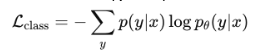 
2. **Contrastive divergence loss**: Encourages separation between real and generated samples.

   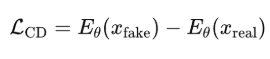

3. **Regularization**: Energy stability constraint.  
        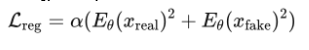

### **Total Loss**

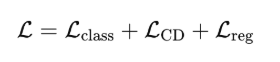


In [5]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = JEMClassifier(hidden_features=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
sampler = Sampler(model, img_shape=(1, 28, 28), sample_size=batch_size)


def jem_loss(energy_real, energy_fake, logits, labels, alpha):
    min_batch_size = min(energy_real.size(0), energy_fake.size(0))
    energy_real = energy_real[:min_batch_size]
    energy_fake = energy_fake[:min_batch_size]

    reg_loss = alpha * (energy_real ** 2 + energy_fake ** 2).mean()
    cdiv_loss = energy_fake.mean() - energy_real.mean()

    class_loss = nn.CrossEntropyLoss()(logits, labels)

    total_loss = reg_loss + cdiv_loss + class_loss
    return total_loss, reg_loss, cdiv_loss, class_loss

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 365kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.29MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.56MB/s]




## **5\. Training Process**

1. **Data Preprocessing**: Normalize input images to \[-1,1\].  
2. **Forward Pass**:  
   * Compute **energy** and **logits** for real images.  
   * Generate **fake images** via MCMC.  
   * Compute **energy** for fake images.  
3. **Loss Computation**:  
   * Compute classification, contrastive divergence, and regularization losses.  
   * Backpropagate and update weights.  
4. **Buffer Update**: Store MCMC samples for later use.  
5. **Repeat for all epochs**.


In [6]:

for epoch in range(epochs):
    model.train()
    train_loss, reg_loss, cdiv_loss, class_loss = 0, 0, 0, 0

    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)

        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs = real_imgs + small_noise
        real_imgs = real_imgs.clamp(min=-1.0, max=1.0)

        fake_imgs = sampler.sample_new_exmps(steps=60, step_size=10)

        energy_real, logits_real = model(real_imgs)
        energy_fake, _ = model(fake_imgs)

        loss, r_loss, c_loss, cls_loss = jem_loss(
            energy_real, energy_fake, logits_real, labels, alpha
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        reg_loss += r_loss.item()
        cdiv_loss += c_loss.item()
        class_loss += cls_loss.item()

    scheduler.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for val_imgs, val_labels in val_loader:
            val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
            _, logits_val = model(val_imgs)
            predictions = torch.argmax(logits_val, dim=1)
            correct += (predictions == val_labels).sum().item()
            total += val_labels.size(0)

    accuracy = correct / total
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Reg Loss: {reg_loss / len(train_loader):.4f}, "
          f"CDiv Loss: {cdiv_loss / len(train_loader):.4f}, Class Loss: {class_loss / len(train_loader):.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/10
Train Loss: 1.1088, Reg Loss: 0.0390, CDiv Loss: -0.0378, Class Loss: 1.1076
Validation Accuracy: 0.8377
Epoch 2/10
Train Loss: 0.5100, Reg Loss: 0.0100, CDiv Loss: 0.0371, Class Loss: 0.4628
Validation Accuracy: 0.8898
Epoch 3/10
Train Loss: 0.3838, Reg Loss: 0.0059, CDiv Loss: 0.0300, Class Loss: 0.3478
Validation Accuracy: 0.9080
Epoch 4/10
Train Loss: 0.3097, Reg Loss: 0.0039, CDiv Loss: 0.0259, Class Loss: 0.2800
Validation Accuracy: 0.9284
Epoch 5/10
Train Loss: 0.2553, Reg Loss: 0.0035, CDiv Loss: 0.0215, Class Loss: 0.2303
Validation Accuracy: 0.9381
Epoch 6/10
Train Loss: 0.2149, Reg Loss: 0.0023, CDiv Loss: 0.0197, Class Loss: 0.1929
Validation Accuracy: 0.9490
Epoch 7/10
Train Loss: 0.1848, Reg Loss: 0.0021, CDiv Loss: 0.0182, Class Loss: 0.1645
Validation Accuracy: 0.9574
Epoch 8/10
Train Loss: 0.1600, Reg Loss: 0.0016, CDiv Loss: 0.0159, Class Loss: 0.1425
Validation Accuracy: 0.9633
Epoch 9/10
Train Loss: 0.1421, Reg Loss: 0.0015, CDiv Loss: 0.0141, Class Loss:



## **6\. Generating Images**

* Use **Langevin Dynamics** for **N=2000** steps to get clear images.  
* Use replay buffer to improve diversity.  
* Visualize generated images.


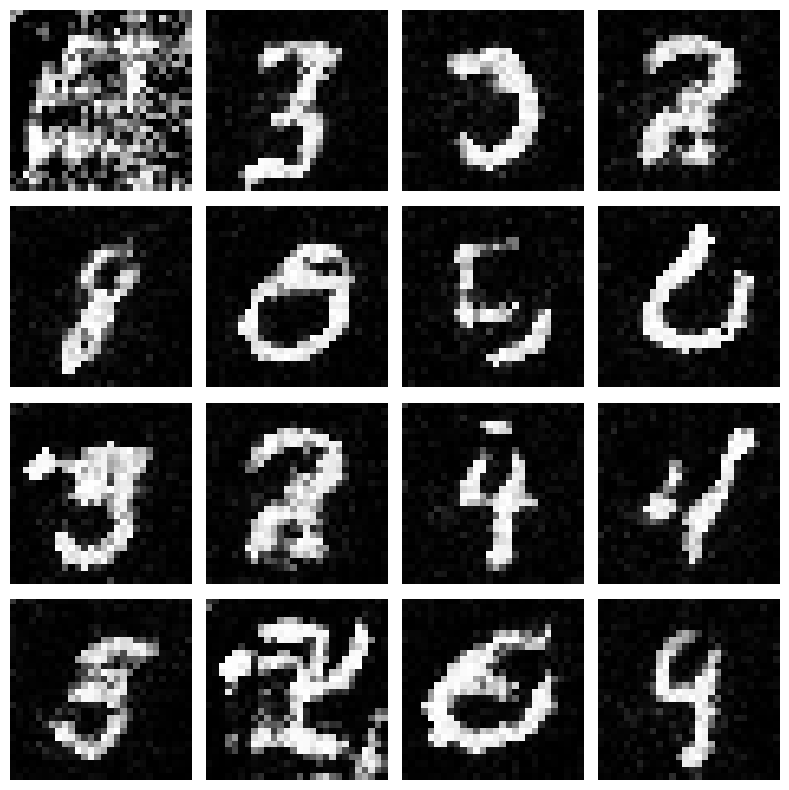

In [7]:

def generate_images_with_sampler(model, sampler, num_images=16, steps=60, step_size=10):
    model.eval()
    with torch.no_grad():
        generated_imgs = sampler.sample_new_exmps(steps=steps, step_size=step_size)
        generated_imgs = generated_imgs[:num_images].detach() 

    return generated_imgs.cpu()


def plot_generated_images(images, num_cols=4):
    num_images = images.size(0)
    num_rows = (num_images + num_cols - 1) // num_cols

    images = (images + 1) / 2 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_images:
            img = images[i].squeeze(0).numpy()
            ax.imshow(img, cmap="gray")
            ax.axis("off")
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.show()


num_images = 16
generated_images = generate_images_with_sampler(model, sampler, num_images=num_images, steps=2000, step_size=0.1)

plot_generated_images(generated_images)